## Global Black Box Optimization with RNNS

In [1]:
import tensorflow as tf
import numpy as np
import visualize as viz

In [2]:
def kernel(x1,x2,l = 0.3):
    return np.exp(-1.0/l**2*np.sum((np.expand_dims(x1,axis=2) - np.expand_dims(x2,axis=1))**2, axis = 3))

def GP(X,A,x, l = 0.3):
    k_xX = kernel(x,X)
    return np.squeeze(np.matmul(k_xX,  A),axis=(2,))

def kernelTF(x1,x2,l = 0.3):
    return tf.exp(-1.0/l**2*tf.reduce_sum((tf.expand_dims(x1,axis=2) - tf.expand_dims(x2,axis=1))**2, axis = 3))

def GPTF(X,A,x, l = 0.3):
    k_xX = kernelTF(tf.expand_dims(x, axis = 1),X)
    return tf.squeeze(tf.matmul(k_xX,  A),axis=(2,))

def normalize(minv, maxv, y):
    return 2*(y-minv)/(maxv-minv)-1.0

In [3]:
def gen_data(n_train, n_test, dim, n_gp_samples, n_mc_samples = 100):
    X = np.random.uniform(low = -1.0, high = 1.0, size = (n_train+n_test, n_gp_samples, dim))
    Y = np.random.uniform(low = -1.0, high = 1.0, size = (n_train+n_test, n_gp_samples))

    K_XX = kernel(X,X)
    A = np.linalg.solve(K_XX, np.expand_dims(Y,axis=2))
    
    mc_samples = np.random.uniform(low = -1.0, high = 1.0, size = [1, n_mc_samples, dim])
    y = GP(X,A,mc_samples)

    min_vals = np.min(y, axis = 1).reshape(n_train+n_test,1)
    max_vals = np.max(y, axis = 1).reshape(n_train+n_test,1)

    return (X[:n_train], A[:n_train], min_vals[:n_train], max_vals[:n_train],\
            X[-n_test:], A[-n_test:], min_vals[-n_test:], max_vals[-n_test:])

In [4]:
# Data
n_train = 1600
n_test = 1600
n_gp_samples = 4
n_mc_samples = 1000
dim = 2

# LSTM Model
n_hidden = 50
n_steps = 10

# Optimization
learning_rate = 0.0001
epochs = 5
batch_size = 160

In [5]:
X_train, A_train, min_train, max_train, X_test, A_test, min_test, max_test = \
                                    gen_data(n_train, n_test, dim, n_gp_samples, n_mc_samples)

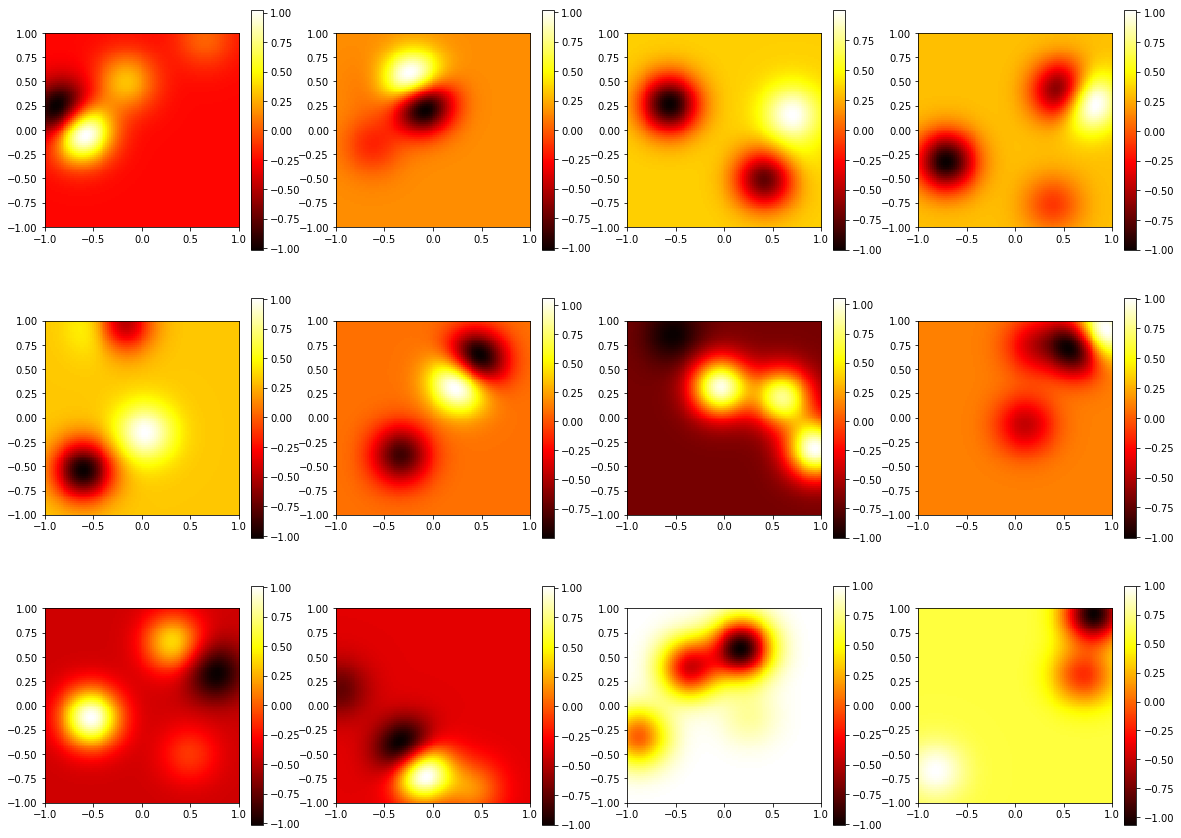

In [6]:
# Visualize Training Data
nplot = 12
idx = np.random.choice(list(range(n_train)), nplot)
f_plot = lambda x: normalize(min_train[idx], max_train[idx], GP(X_train[idx], A_train[idx], x)) 
viz.plot_training_data(f_plot, dim, nplot, heat = True)

In [7]:
# LSTM Output Weights
weights = {
    'out': tf.Variable(tf.random_normal([n_hidden, dim]))
}
biases = {
    'out': tf.Variable(tf.random_normal([dim]))
}

In [8]:
# Create Model
size = tf.placeholder(tf.int32,[])

Xt = tf.placeholder(tf.float32, [None, n_gp_samples, dim])
At = tf.placeholder(tf.float32, [None, n_gp_samples, 1])
mint = tf.placeholder(tf.float32, [None, 1])
maxt = tf.placeholder(tf.float32, [None, 1])

x_0 = -0.0*tf.ones([size, dim])
h_0 = tf.ones([size, n_hidden])
c_0 = tf.ones([size, n_hidden])

state = (c_0, h_0)
x = x_0
y = normalize(mint, maxt, GPTF(Xt,At,x))
sample_points = [x]

f_min = y
f_sum = 0

# No idea why this is necessary 
cell = tf.contrib.rnn.LSTMCell(num_units = n_hidden, reuse=None)
cell(tf.concat([x, y], 1), state, scope='rnn_cell')
cell = tf.contrib.rnn.LSTMCell(num_units = n_hidden, reuse=True)

for i in range(n_steps):
    h, state = cell(tf.concat([x, y], 1), state, scope='rnn_cell')
    x = tf.tanh(tf.matmul(h, weights['out']) + biases['out'])
    sample_points.append(x)
    
    y = normalize(mint, maxt, GPTF(Xt,At,x))
    
    f_min = tf.minimum(y, f_min)
    f_sum += tf.reduce_mean(y)

f_min = tf.reduce_mean(f_min)
loss = f_sum / n_steps

In [9]:
train_step = tf.train.AdamOptimizer(learning_rate).minimize(loss)

In [10]:
sess = tf.InteractiveSession()
sess.run(tf.global_variables_initializer())

train_loss_list = []
test_loss_list = []
train_fmin_list = []
test_fmin_list = []

In [11]:
# Train the Network
print("Function Dimension: \t\t"+str(dim))
print("Number of Training Samples: \t"+str(n_train))
print("Number of Test Samples: \t"+str(n_test))
print("Batch size: \t\t\t"+str(batch_size))
print("Number of hidden Units: \t"+str(n_hidden))
print("Sequence length: \t\t"+ str(n_steps))
print("Epochs: \t\t\t"+str(epochs))
print("Learning rate: \t\t\t"+str(learning_rate))
print("------------------------------------------------------------------------------------")

for ep in range(epochs):
    for batch in range(n_train//batch_size):
        X_batch = X_train[batch*batch_size:(batch+1)*batch_size]
        A_batch = A_train[batch*batch_size:(batch+1)*batch_size]
        min_batch = min_train[batch*batch_size:(batch+1)*batch_size]
        max_batch = max_train[batch*batch_size:(batch+1)*batch_size]
        
        sess.run([train_step], feed_dict={Xt: X_batch, At: A_batch, mint: min_batch, maxt: max_batch, size: batch_size})
    
    train_loss, train_fmin = sess.run([loss, f_min], feed_dict=\
                                      {Xt: X_train, At: A_train, mint: min_train, maxt: max_train, size: n_train})
    test_loss, test_fmin = sess.run([loss, f_min], feed_dict=\
                                      {Xt: X_test, At: A_test, mint: min_test, maxt: max_test, size:n_test})
    
    train_loss_list += [train_loss]
    test_loss_list += [test_loss]
    train_fmin_list += [train_fmin]
    test_fmin_list += [test_fmin]
    
    if ep < 10 or ep % (epochs // 10) == 0 or ep == epochs-1:
        print("Ep: " +"{:4}".format(ep)+" | TrainLoss: "+"{: .3f}".format(train_loss)
              +" | TrainMin: "+ "{: .3f}".format(train_fmin)+ " | TestLoss: "+
              "{: .3f}".format(test_loss)+" | TestMin: "+ "{: .3f}".format(test_fmin))

Function Dimension: 		2
Number of Training Samples: 	1600
Number of Test Samples: 	1600
Batch size: 			160
Number of hidden Units: 	50
Sequence length: 		10
Epochs: 			5
Learning rate: 			0.0001
------------------------------------------------------------------------------------
Ep:    0 | TrainLoss:  0.006 | TrainMin: -0.306 | TestLoss:  0.001 | TestMin: -0.307
Ep:    1 | TrainLoss: -0.004 | TrainMin: -0.311 | TestLoss: -0.008 | TestMin: -0.322
Ep:    2 | TrainLoss: -0.012 | TrainMin: -0.318 | TestLoss: -0.009 | TestMin: -0.314
Ep:    3 | TrainLoss: -0.013 | TrainMin: -0.314 | TestLoss: -0.009 | TestMin: -0.312
Ep:    4 | TrainLoss: -0.015 | TrainMin: -0.313 | TestLoss: -0.011 | TestMin: -0.309


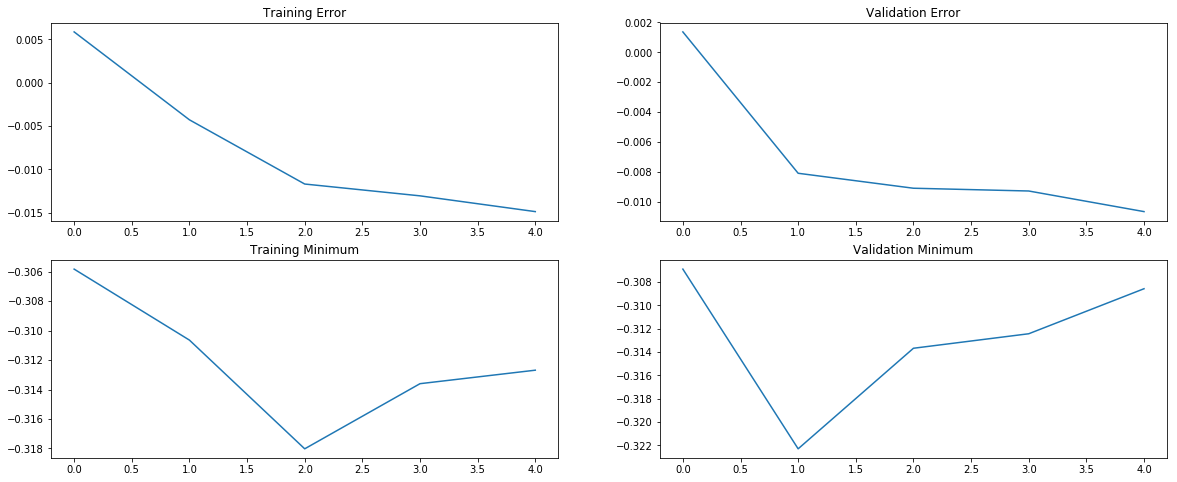

In [12]:
viz.visualize_learning(train_loss_list, test_loss_list, train_fmin_list, test_fmin_list)

In [13]:
# Extract Samples
samples_train = sess.run([sample_points], feed_dict={Xt: X_train, At: A_train, size : n_train, mint: min_train, maxt: max_train})
samples_train = np.array(samples_train[0]).reshape(n_steps+1,n_train, dim).transpose((1,0,2))
samples_test = sess.run([sample_points], feed_dict={Xt: X_test, At: A_test, size : n_test, mint: min_test, maxt: max_test})
samples_test = np.array(samples_test[0]).reshape(n_steps+1,n_test, dim).transpose((1,0,2))

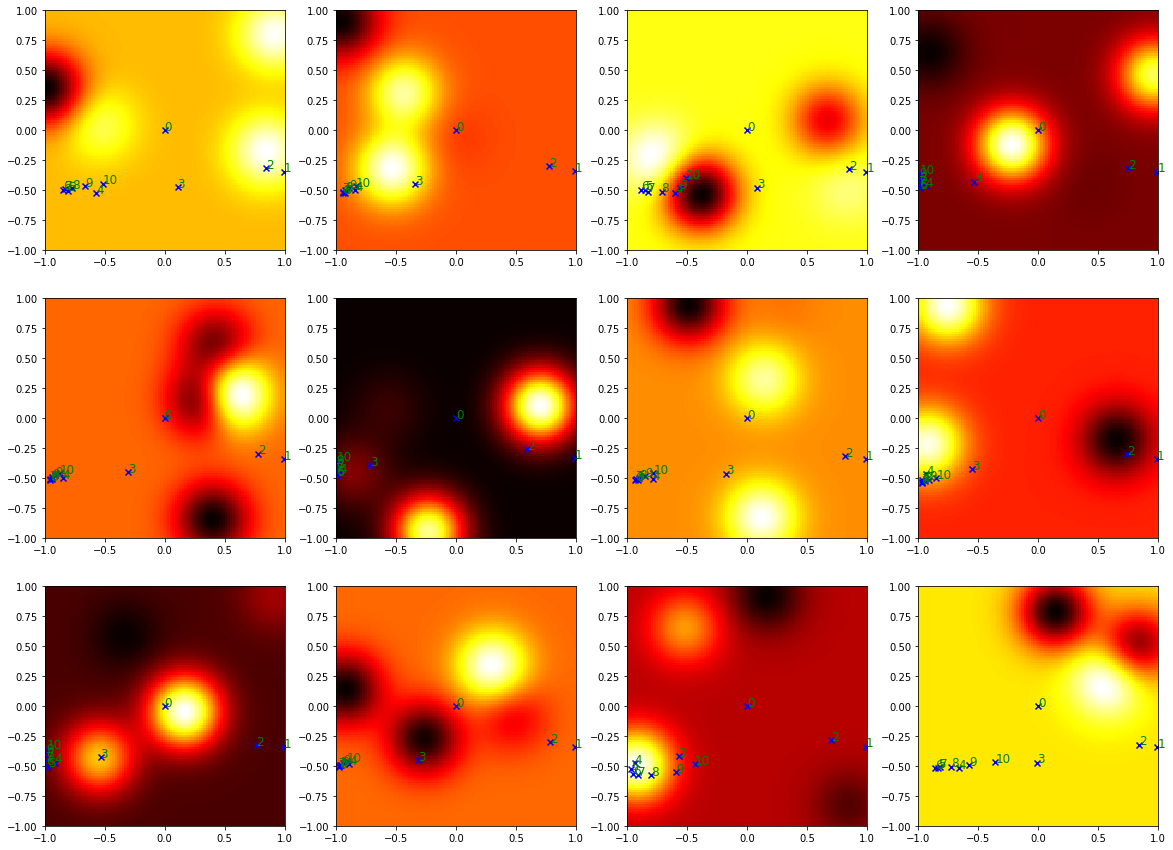

In [14]:
# Show results
nplot = 12
idx = np.random.choice(list(range(n_train)), nplot)
f_plot = lambda x: normalize(min_train[idx], max_train[idx], GP(X_train[idx], A_train[idx], x)) 
viz.plot_result(f_plot, dim, nplot, samples_train[idx])